<h1 align="center"> Machine Learning: Boston Housing Data Set</h1><br>

<strong><p style="font-size:120%;">Assignment Prompt: </strong> Perform Stacking Ensemble analysis on the Boston Housing Data set. You can use Python, Weka, KNIME or other tool to perform Stacking or write your own version in Python code. Include interesting plots and attribute importance analysis to support the choice of the final model configuration chosen. Any combination of any of the Machine learning algorithms we have covered in the class so far or you are already familiar with is acceptable to be used in the Stacking Ensemble.

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split

<strong></strong> 



<strong><p style="font-size:120%;">Load the Dataset</strong> 

In [3]:
boston_data = load_boston()

<strong><p style="font-size:120%;">Basic Exploration of the Dataset</strong> 

In [4]:
boston_data.keys()

['data', 'feature_names', 'DESCR', 'target']

In [5]:
boston_data['data'][0]

array([  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
         0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
         6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
         2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
         4.98000000e+00])

In [6]:
boston_data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='|S7')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(boston_data.data,
        boston_data.target, test_size=0.20, random_state=2)
Dimensions = ['X_train', 'y_train', 'X_test', 'y_test' ]
shapes = {index: str(i) for index, i in enumerate([X_train.shape, y_train.shape, X_test.shape, y_test.shape ])}.values()  
pd.DataFrame(data = zip(Dimensions, shapes), columns = ['Data', 'Shapes'])

,Data,Shapes
0,X_train,"(404, 13)"
1,y_train,"(404,)"
2,X_test,"(102, 13)"
3,y_test,"(102,)"


<strong><p style="font-size:120%;">Feature Importance</strong> 

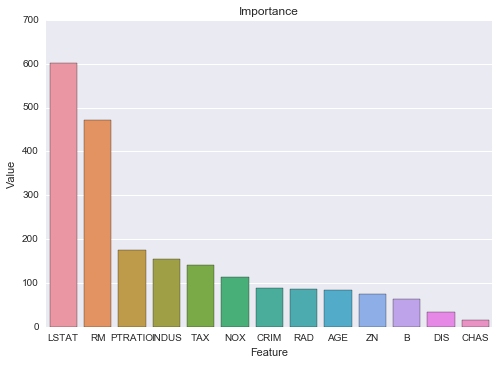

In [22]:
fs=SelectKBest(score_func=f_regression, k=7)
X_new=fs.fit_transform(boston_data.data, boston_data.target)
feat_imp = pd.DataFrame(zip(boston_data.feature_names, fs.scores_,
                            fs.get_support()), columns = ["Features","Score","Select"])
feat_imp = feat_imp.sort_values(["Score"],ascending = False)

ax = sns.barplot(x="Features", y="Score", data=feat_imp)
ax.set_xlabel('Feature')
ax.set_ylabel('Value')
ax.set_title('Importance');

<strong><p style="font-size:120%;">Features </strong>

    CRIM: per capita crime rate by town

    ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

    INDUS: proportion of non-retail business acres per town

    CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

    NOX: nitric oxides concentration (parts per 10 million)

    RM: average number of rooms per dwelling

    AGE: proportion of owner-occupied units built prior to 1940

    DIS: weighted distances to five Boston employment centres

    RAD: index of accessibility to radial highways

    TAX: full-value property-tax rate per 10,000 dollars

    PTRATIO: pupil-teacher ratio by town

    B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

    LSTAT: % lower status of the population

    MEDV: Median value of owner-occupied homes in $1000's
    
(gotten from http://datascience-is-fun.com/Python/Housing.html) 


<strong><p style="font-size:120%;">Feature Analysis </strong> The most important features are:
<ol>
<li> LSTAT: % lower status of the population </li>
<li> RM: average number of rooms per dwelling </li>
</ol>

One part of the data I am confused about is why TAX isn't higher on the list as property tax is a percentage of a house's value typically. 

In [15]:
class Stack():

    def __init__(self, stack0, stack1):
        self.__stack0 = stack0
        self.__stack1 = stack1

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
        meta_input = [regressor.fit(X_train, y_train).predict(X_test) for regressor in self.__stack0]
        X_meta = np.array(meta_input).T
        self.__stack1.fit(X_meta, y_test)
        return self

    def predict(self, X):
        self.base_regressors_predict_ = {index: regressor.predict(X) for index,regressor in enumerate(self.__stack0)}.values()
        X_meta = np.array(self.base_regressors_predict_).T
        return self.__stack1.predict(X_meta)

    def scores(self, X, y):
        self.score_base_regressors_ = [regressor.score(X, y) for regressor in self.__stack0]
        X_meta = np.array([regressor.predict(X) for regressor in self.__stack0]).T
        self.score_meta_regressor_ = self.__stack1.score(X_meta, y)
        self.mse_base_regressors_ = [mean_squared_error(y, X_meta[:, i]) for i in xrange(X_meta.shape[1])]
        self.mse_meta_regressor_ = mean_squared_error(y, self.__stack1.predict(X_meta))

In [20]:
def evaluate_model(stack0, stack1, names):
    stacked_regressor = Stack(stack0 = stack0, stack1 = stack1).fit(X_train, y_train)
    stacked_regressor.scores(X_test, y_test)
    predicted_y = stacked_regressor.predict(X_test)
    df = pd.DataFrame(stacked_regressor.base_regressors_predict_ + [predicted_y, y_test], index=names + ["Original"]).T
    pd.DataFrame({"Mean Squared Error": stacked_regressor.mse_base_regressors_ + [stacked_regressor.mse_meta_regressor_],
    "SCORE" : stacked_regressor.score_base_regressors_ + [stacked_regressor.score_meta_regressor_]}, index=names).plot(
    kind='bar', subplots=True, figsize=(10, 15), legend = False)

<strong><p style="font-size:120%;">Stack0</strong>

LinearRegression<br>
DecisionTreeRegressor(max_depth=3, max_features= 5)<br>


<strong><p style="font-size:120%;">Stack1</strong>

Ridge<br>

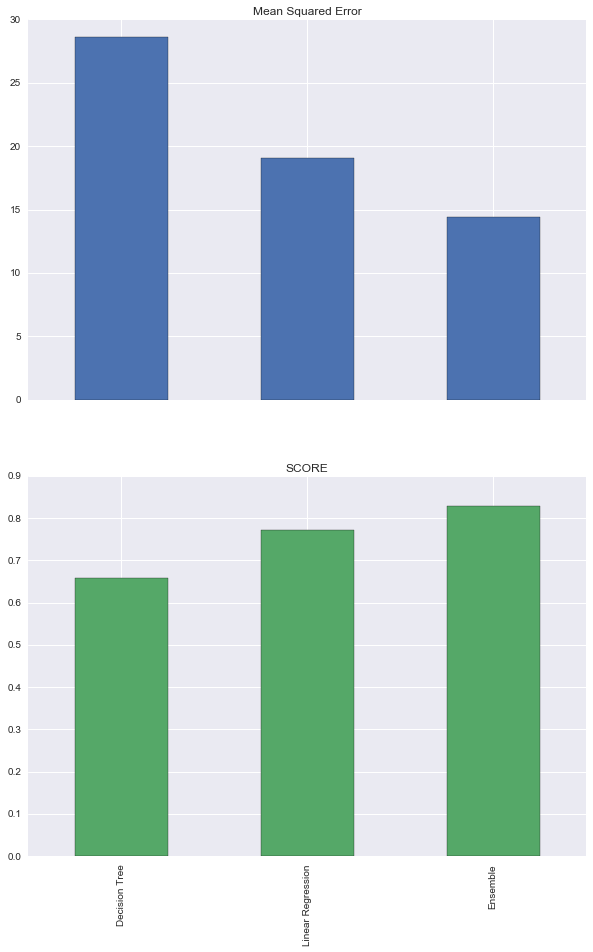

In [24]:
stack0=[DecisionTreeRegressor(max_depth=3, max_features= 5), LinearRegression()]
stack1 = Ridge()
models = ["Decision Tree", "Linear Regression", "Ensemble"]
evaluate_model(stack0, stack1 , models)

<strong><p style="font-size:120%;">Analysis: </strong> Ensembles tend to yield better results when there is a significant diversity among the models which was the result of this analysis. The decision tree overfit the model and Linear Regression reduced the overfit so the ensemble landed up working well.